In [1]:
library(tidyverse)
library(ncdf4)
library(viridis)
library(fields)
library(rstan)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘purrr’ was built under R version 3.6.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: viridisLite

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: maps


A

In [2]:
nc <- nc_open("data/Zinser_SizeDist_calibrated-26-6_1hr.nc")
PAR   <- ncvar_get(nc,'PAR')
w_obs <- ncvar_get(nc,'w_obs')
m     <- ncvar_get(nc,'m')
delta_v_inv <- ncvar_get(nc,'delta_v_inv')
v_min       <- ncvar_get(nc,'v_min')
time  <- ncvar_get(nc,'time')
time <- as.POSIXct(time*60, origin="2009-05-01")
delta_v <- 1/delta_v_inv
v       <- v_min*2^(0:25*delta_v) 

In [3]:
df <- read.csv("data/Zinser_Figure2A.csv")
time2 <- as.POSIXct(df[,1]*60*60, origin="2009-05-01")

resol.i <- 60
abundance <- approx(time2, rowMeans(df[,c(3,2)]), xout=seq(min(time2), max(time2), by=60*resol.i))
clean <- smooth.spline(abundance, df=15) # smooth abundance data using spline


df2 <- read.csv("data/Zinser_Figure3.csv")

- ### Equation division rate (assuming exponential growth)
$$
DR = ln(\frac{N_1/N_0}t)

In [4]:
dr <- diff(log(clean$y))/diff(clean$x/3600) # calculate hourly division rate

[1] "Division rate =  0.631 / day"


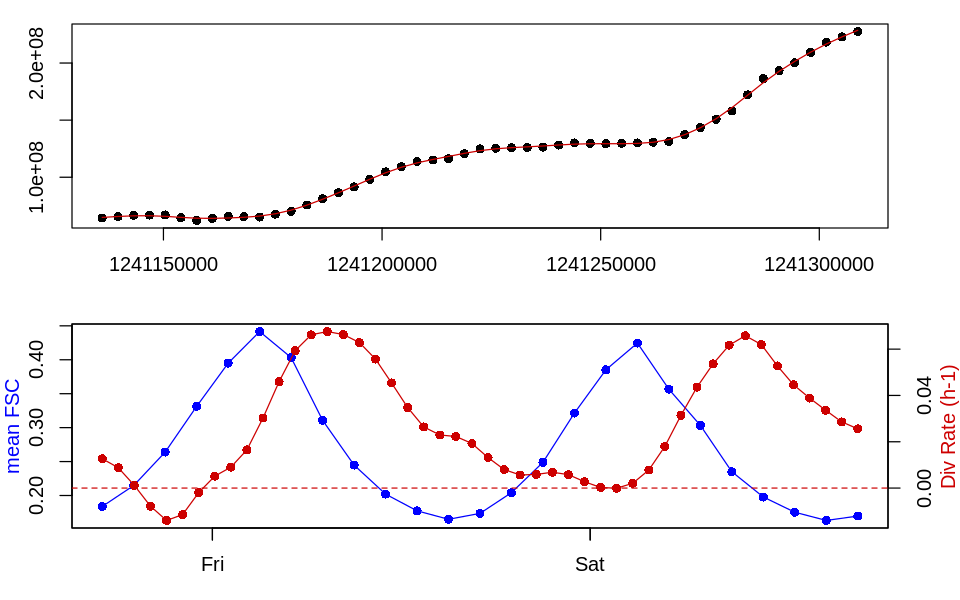

In [5]:
options(repr.plot.width = 8, repr.plot.height = 5)

par(mfrow=c(2,1), mar=c(3,3,1,3))
plot(abundance, pch=NA)
#polygon(x=rep(c(1200,1800,2640,3240),each=2), y=rep(c(1,10^9,10^9,1),2), border=NA, col='lightgrey')
points(abundance, pch=16)
lines(clean,col="red3" )
plot(time2, df[,c(4)], pch=NA, xlab=NA, ylab=NA)
#polygon(x=rep(c(1200,1800,2640,3240),each=2), y=rep(c(-1,1,1,-1),2), border=NA, col='lightgrey')
lines(time2, df[,c(4)], col='blue1', type="o", pch=16)
par(new=T)
plot(x=time[-1],y=dr, type='o', pch=16, xaxt='n', yaxt='n', col="red3", xlab=NA, ylab=NA)
axis(4) 
mtext("Div Rate (h-1)", 4,2, col="red3")
mtext("mean FSC", 2,2, col="blue1")
abline(h=0, lty=2,col="red3")
print(paste("Division rate = ",round(24*mean(dr),3), "/ day"))


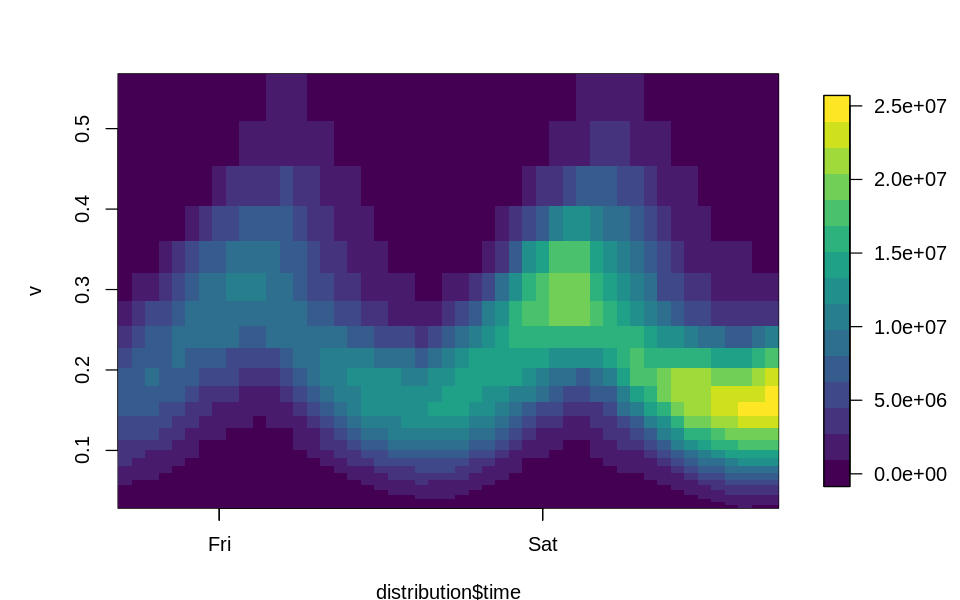

In [6]:
w_obs2 <- round(w_obs * abundance$y)
dist <- as.data.frame(w_obs2)
dist$time <- time

dist <- dist[,c(27,1:26)] # reorganize dataframe to be compatible with ssPopModel

colnames(dist) <- c("time", v)

### select 1 day Size distribution
id <- c(1:25)   
distribution <- as.data.frame(dist[,])

options(repr.plot.width = 8, repr.plot.height = 5)
image.plot(x=distribution$time,y=v,z=as.matrix(distribution[,-c(1)]), col=viridis(15))

In [7]:
## PAR data
# resolution
resol <- 10 # in minutes

# select PAR data covering the range of the size distribution
par <- data.frame(time=time, par=PAR)
par <- subset(par, time  >= min(distribution$time) & time  < max(distribution$time))

# Change temporal resolution 
E <- approx(par$time, par$par, xout=seq(min(par$time), max(par$time), by=60*resol))

# smooth spline
ep <- smooth.spline(E, all.knots=TRUE)
Edata <- ep$y
Edata[Edata < 0] <- 0

# #plot
# options(repr.plot.width = 8, repr.plot.height = 8)
# plot(par$time,par$par, type='p', xlab=NA, ylab="Light")
# points(ep$x,Edata, col=4, lwd=3)

In [8]:
models <- c('m1','m2','m3','m4','m5','m6') # old version
#    'm1': '../stancode/matrixmodel_estinilnorm_monodelta_respv2_normparam_trackgrowth_xval.stan',
#    'm2': '../stancode/matrixmodel_estinilnorm_monodelta-lightsig_respv2_normparam_trackgrowth_xval.stan',
#    'm3': '../stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv6_normparam_trackgrowth_xval.stan',
#    'm4': '../stancode/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respiv6_normparam_trackgrowth_xval.stan',
#    'm5': '../stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv7_normparam_trackgrowth_xval.stan',
#    'm6': '../stancode/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respiv7_normparam_trackgrowth_xval.stan',
models <- c('c1','c2','c3','c4','c5','c6','c7') # new version
#    'c1':'../stancode_gallery1/matrixmodel_multinom_estinilnorm_freedelta_normparam_trackgrowth_xval.stan',
#    'c2':'../stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_normparam_trackgrowth_xval.stan',
#    'c3':'../stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_gammaiv6_normparam_trackgrowth_xval.stan',
#    'c4':'../stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respv1_normparam_trackgrowth_xval.stan',
#    'c5':'../stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respv2_normparam_trackgrowth_xval.stan',
#    'c6':'../stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respiv6_normparam_trackgrowth_xval.stan',
#    'c7':'../stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respiv7_normparam_trackgrowth_xval.stan',

SF=ZN <- list()
for(i in 1:length(models)){
    #SF[[i]] <- read.csv(paste('fit',models[i],'seaflow.csv',sep='_'))
    ZN[[i]] <- read.csv(paste('parameter_plots/fit',models[i],'zinser_1hr.csv',sep='_'))
}

In [9]:
##################
### parameters ###
##################
pars <- c('gamma_max','E_star','divrate')

PARS_sf=PARS_zn   <- array(NA,dim=c(dim(ZN[[1]])[1],length(pars),length(models)))

for(j in 1:length(models)){
    pars_sf=pars_zn                     <- matrix(NA,dim(ZN[[1]])[1],length(pars))
    colnames(pars_sf)=colnames(pars_zn) <- pars
    for(i in 1:length(pars)){
        #pars_sf[,i] <- SF[[j]][,grep(pars[i],colnames(SF[[j]]))]
        pars_zn[,i] <- ZN[[j]][,grep(pars[i],colnames(ZN[[j]]))]
    }
    #PARS_sf[,,j] <- pars_sf
    PARS_zn[,,j] <- pars_zn
}


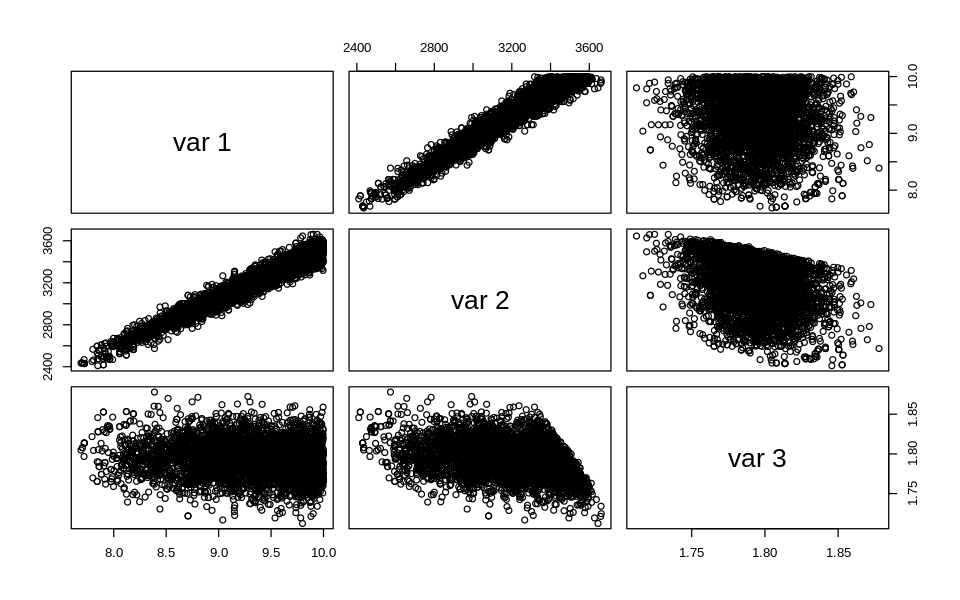

In [10]:
pairs(PARS_zn[,,1])

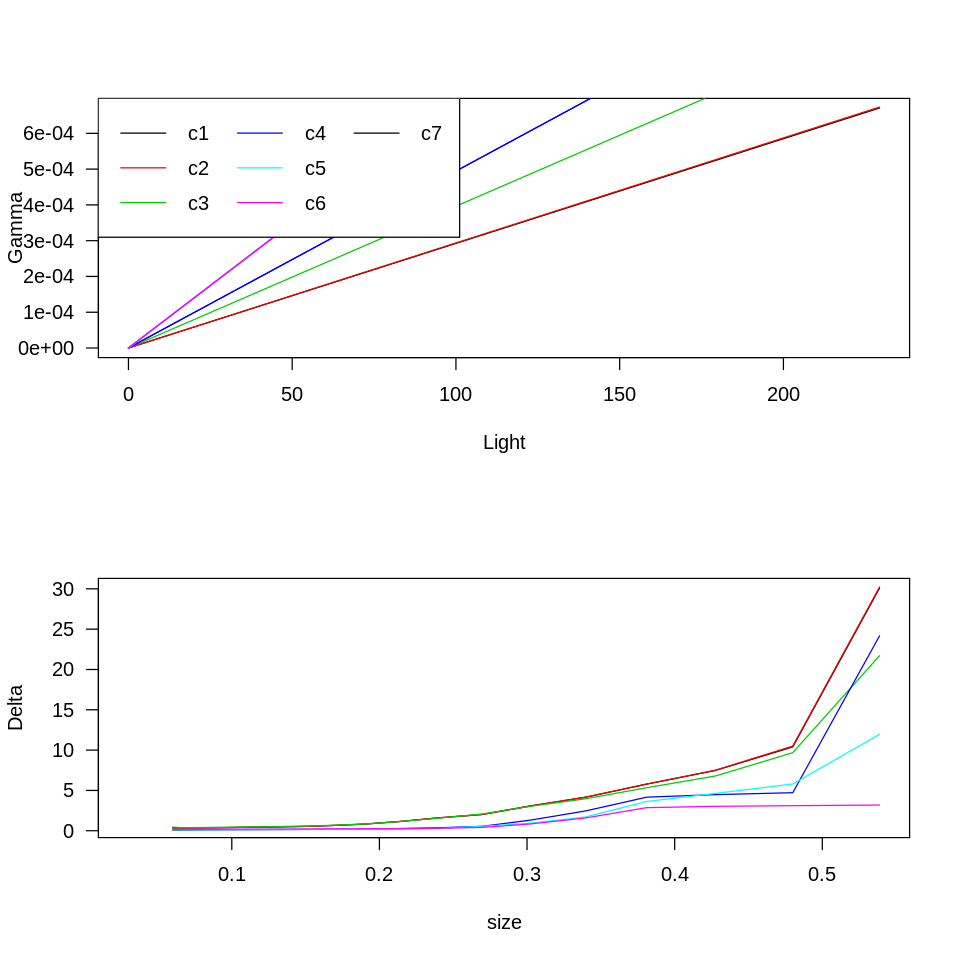

In [11]:
source("scripts/functions_model.R")
id1 <- which(colnames(ZN[[1]]) == "delta_max.1.")
id2 <- which(colnames(ZN[[1]]) == "delta_max.20.")

options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(2,1))
plot(Edata, gamma_t(Edata, mean(ZN[[1]]$gamma_max), mean(ZN[[1]]$E_star)), type='l', xlab="Light", ylab=paste("Gamma"), las=1)
for(i in 2:6) lines(Edata, gamma_t(Edata, mean(ZN[[i]]$gamma_max), mean(ZN[[i]]$E_star)), col=i)
legend("topleft",models, col=1:6, lwd=1, ncol=3)

plot(v[7:26], colMeans(ZN[[1]][id1:id2]), type='l', xlab="size", ylab=paste("Delta"), las=1, xlim=range(v))    
for(i in 2:6){
    id1 <- which(colnames(ZN[[i]]) == "delta_max.1.")
    id2 <- which(colnames(ZN[[i]]) == "delta_max.20.")
    lines(v[7:26], colMeans(ZN[[i]][id1:id2]), col=i)
}

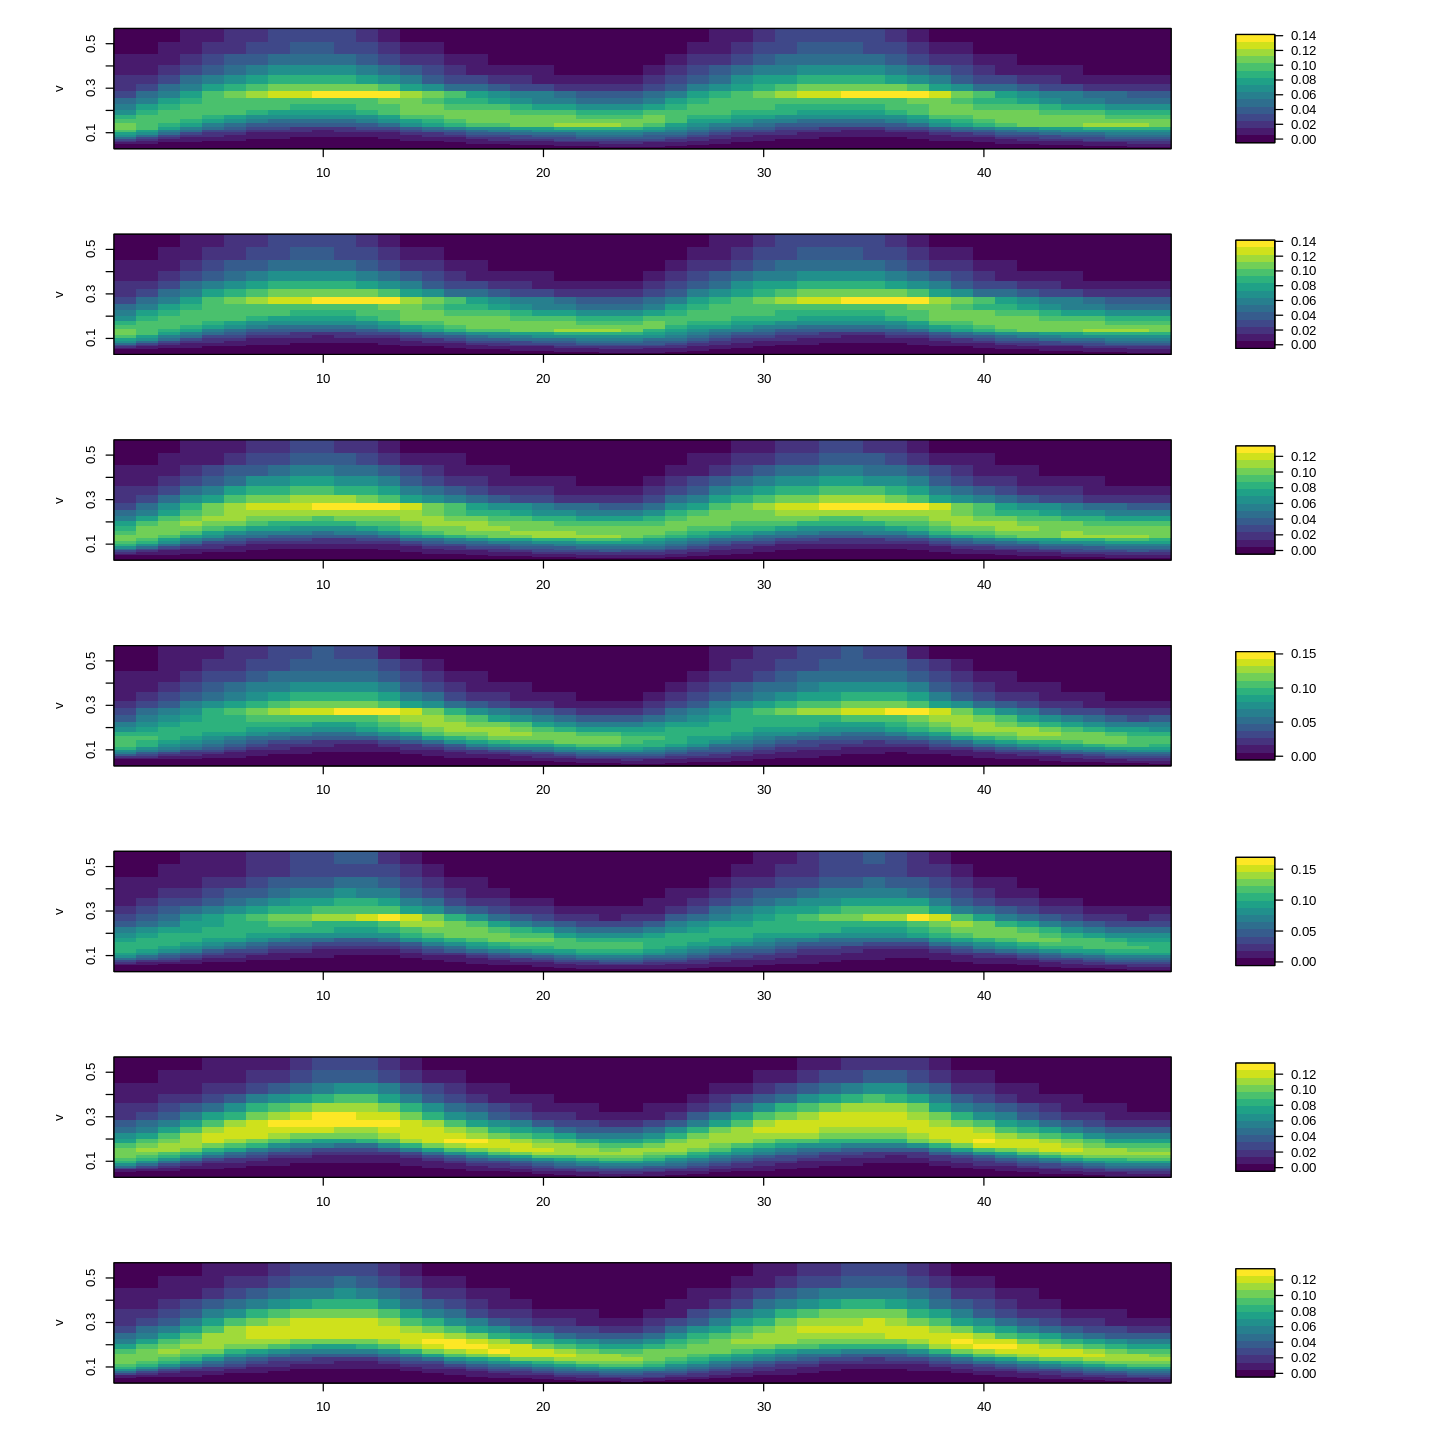

In [34]:
options(repr.plot.width=12, repr.plot.height=12)
par(mfrow=c(7,1),mar=c(2,4,1,2))

Nproj <- Vproj <- res <- list()
for(i in 1:length(models)){
    id1 <- which(colnames(ZN[[i]]) == "mod_obspos.1.1.")
    id2 <- which(colnames(ZN[[i]]) == "mod_obspos.26.48.")
    Nproj[[i]] <- matrix(data=colMeans(ZN[[i]][id1:id2]), nrow=26, ncol=48) * clean$y[1]
    Vproj[[i]] <- t(t(Nproj[[i]]) / colSums(Nproj[[i]]))  
    res[[i]] <- w_obs2[-49,]-t(Vproj[[i]])
    image.plot(x=seq(1,48,1),y=v,t(Vproj[[i]]),col=viridis(15),xlab=''); box()
}


[1] "daily growth rate= 1.83"
[1] "daily growth rate= 1.84"
[1] "daily growth rate= 1.68"
[1] "daily growth rate= 0.94"
[1] "daily growth rate= 0.72"
[1] "daily growth rate= 0.55"
[1] "daily growth rate= 0.53"


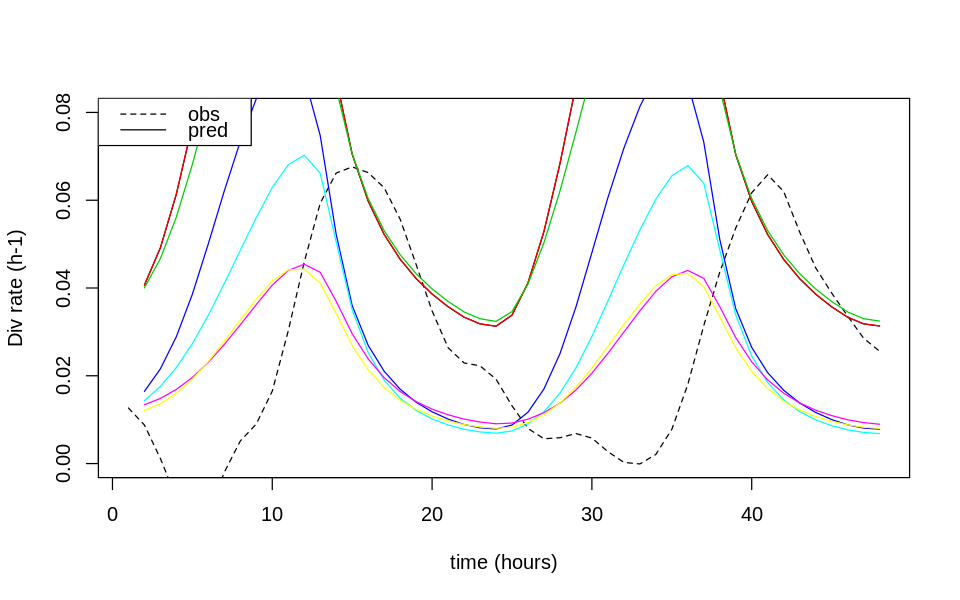

In [35]:
###############################
## Division rate calculation ##
###############################

mu_N <- list()
for(i in 1:length(models)){
    mu_N[[i]] <- diff(log(colSums(Nproj[[i]], na.rm=T)))
    print(paste("daily growth rate=",round(24*mean(mu_N[[i]], na.rm=T),2)))
}

#plot
options(repr.plot.width = 8, repr.plot.height = 5)
plot(seq(1,48,1), y=dr, lty=2,type='l', ylim=c(0,0.08), xlab='time (hours)', ylab="Div rate (h-1)")
for(i in 1:length(models)) lines(seq(2,48,1), y=mu_N[[i]], col=i)
legend("topleft",c("obs","pred"), lty=c(2,1))

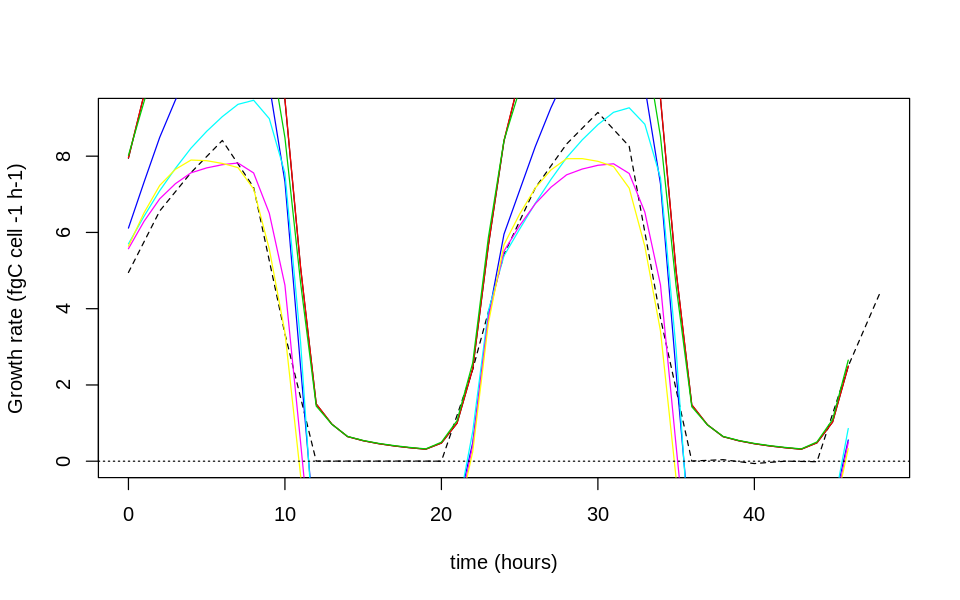

In [37]:
#############################
## Growth rate calculation ##
#############################
#c <- 261 * (1*v)^0.861 # Menden-Deuer # NOTE we can multiply Volume by 1.5 to make our estimates of light-scatter based volume fit Carbon measurements
c <- 330 * (1*v)^0.861 # Casey (mean diam 0.55 micron -> 25 fgC per cell)
light <- approx(par$time, par$par, xout=seq(min(par$time), max(par$time), by=60 * 60))$y

# Obs Net growth rate
biom1 <-  diag(c) %*%  t(as.matrix(distribution[,-c(1)]))
gr1 <- diff(colSums(biom1)) / rowSums(distribution[,-c(1)])[-1]

# Proj Net growth rate
gr <- list()
for(i in 1:length(models)){
    biom <-  diag(c) %*%  Nproj[[i]]
    gr[[i]] <- diff(colSums(biom)) / colSums(Nproj[[i]])[-1]
}

options(repr.plot.width = 8, repr.plot.height = 5)
plot(seq(0,48,2), df2[,3], type="l", lty=2, xlab='time (hours)', ylab="Growth rate (fgC cell -1 h-1)")
for(i in 1:length(models)) lines(seq(0,46,1), gr[[i]], col=i); abline(h=0, lty=3)

Warning message in matrix(c(1:8), 3, 2, byrow = FALSE):
“data length [8] is not a sub-multiple or multiple of the number of rows [3]”


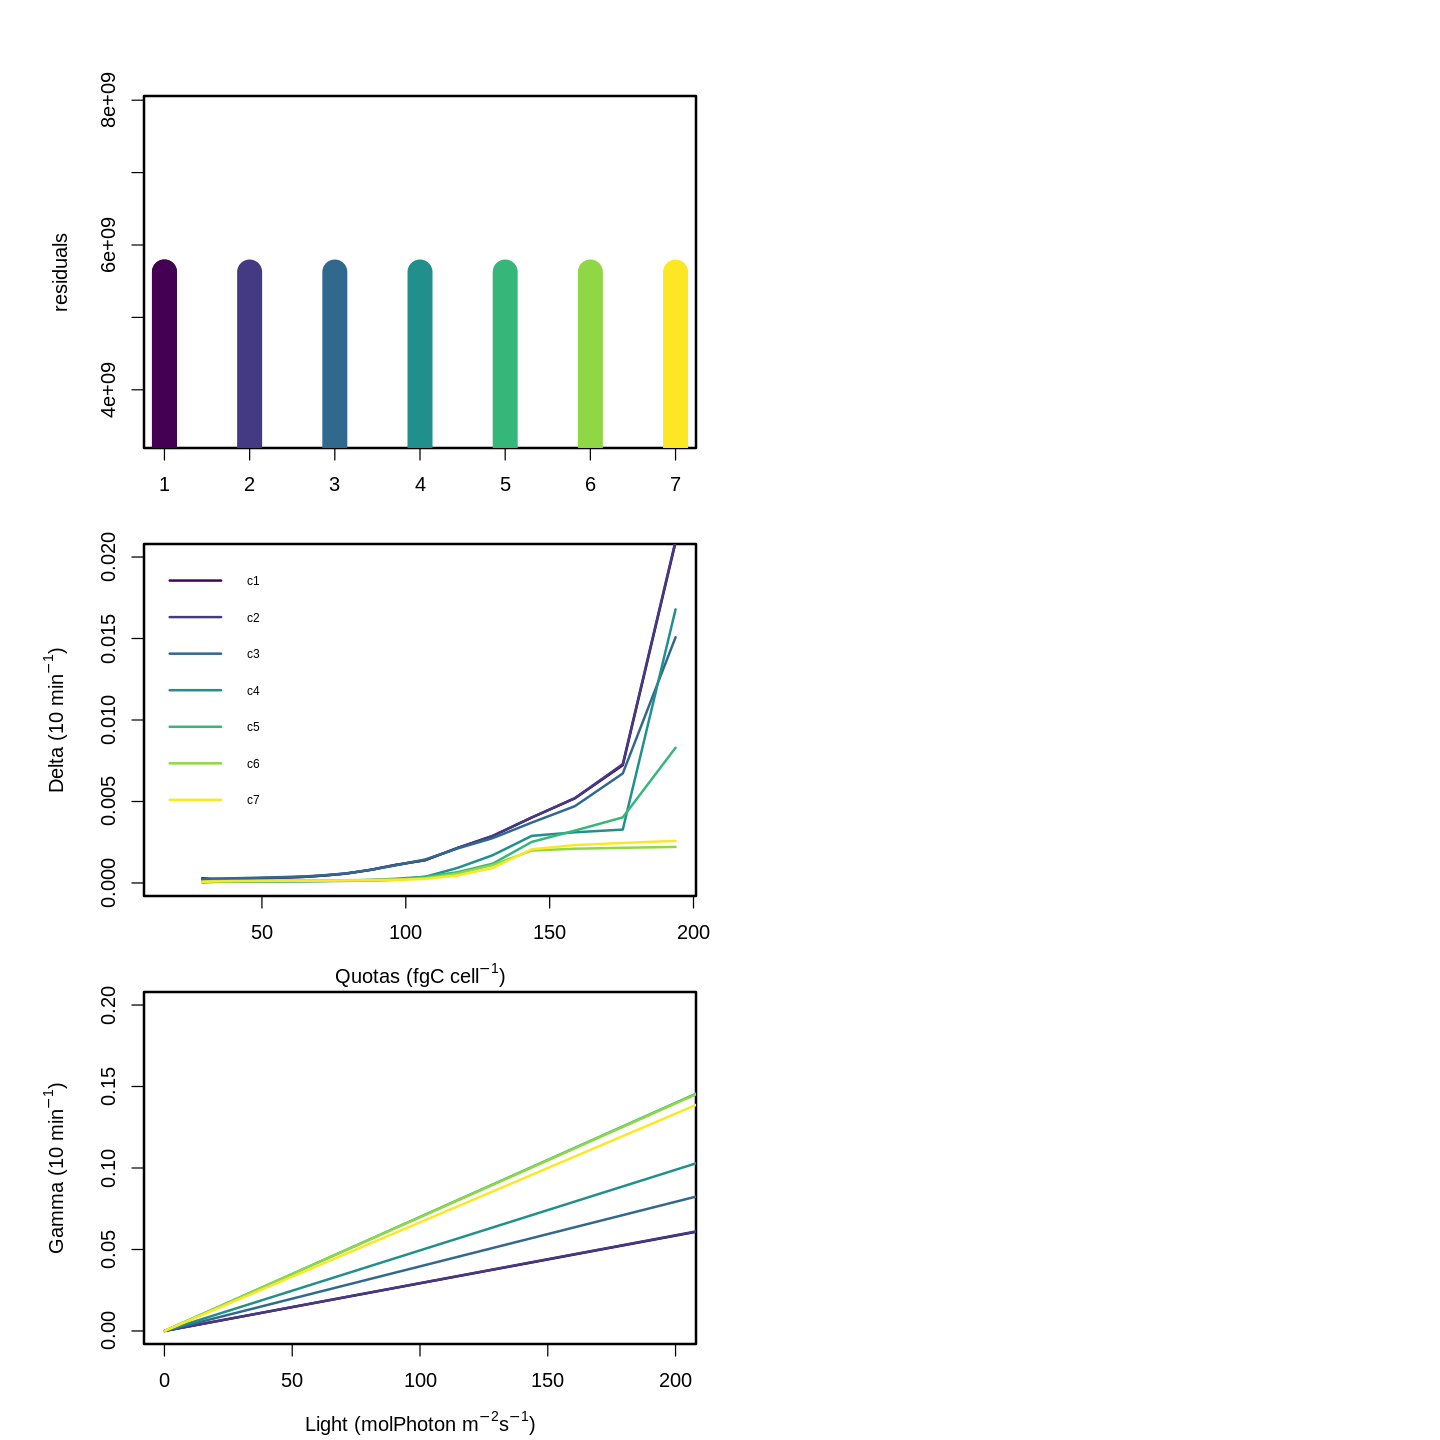

In [48]:
r <- range(as.POSIXct(distribution$time, origin="1970-01-01"))
options(repr.plot.width = 12, repr.plot.height = 12)
layout(matrix(c(1:8), 3, 2, byrow = FALSE))
par(mar=c(1,5,3,1), oma=c(3,1,1,1), lwd=2, cex=1)

## Comparison Obs vs Model
# plot(unlist(div), ylim=c(0,2)); abline(h=0.63, lty=3)
# arrows(1:7, unlist(div)-unlist(div.sd)/2, 1:7, unlist(div)+unlist(div.sd)/2, length=0.05, angle=90, code=3)

plot(1, sum(abs(res[[1]])), xlim=c(1,length(models)), ylim=c(0,7), type="h", lwd=20, ylab="residuals")
for(i in 1:7) points(i,  sum(abs(res[[i]])),col=viridis(length(models))[i], type="h", lwd=20)

plot(0,0,xlab="size", ylab=expression('Delta (10 min'^-1*')'), xlim=range(c), ylim=c(0,0.02))    
for(i in 1:7){
    id1 <- which(colnames(ZN[[i]]) == "delta_max.1.")
    id2 <- which(colnames(ZN[[i]]) == "delta_max.20.")
    lines(c[7:26], colMeans(ZN[[i]][id1:id2])/1440, col=viridis(length(models))[i])
    }
legend("topleft", models, bty="n", col=viridis(length(models)), lty=1, cex=0.6)
mtext(expression('Quotas (fgC cell'^-1*')'), 1,3)

plot(0, 0, ylim=c(0, 0.2), pch=NA, xlim=c(0, 200), ylab=expression('Gamma (10 min'^-1*')'))
for(i in 1:7) lines(Edata, 100*gamma_t(Edata, mean(ZN[[i]]$gamma_max), mean(ZN[[i]]$E_star)), col=viridis(length(models))[i])
mtext(expression('Light (molPhoton m'^-2*'s'^-1*')'),1,3)

# plot(time, abundance/10^6, type='l', lwd=4, xaxt="n", ylab=expression('Abundance (10'^6*'cells L'^-1*')'), xlim=range(time))
# for(i in 1:length(models)) lines(time[-1], colSums(Nproj[[i]])/10^6, col=viridis(length(models))[i])
# axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))

# plot(x=time[-24],y=dr, type='l', lwd=4, ylim=c(0, 0.15), xaxt='n',xlim=range(time), ylab="Division rate (h-1)")
# for(i in 1:length(models))lines(x=distribution$time[-c(23,24)],y=mu_N[[i]], lwd=2, col=viridis(length(models))[i])
# axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
# plot(time, df2[,3], type='l', lwd=4, xaxt="n", ylim=c(0,25), xlim=range(time),ylab="Growth rate (fgC cell-1 h-1)")
# for(i in 1:length(models))lines(x=distribution$time[-c(23,24)],y=gr[[i]], col=viridis(length(models))[i])
# # axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
# # plot(time, 0.5 * ( - df2[,3] + df2[,7]), xaxt="n", type='l', lwd=4, ylim=c(0,5), xlim=range(time), ylab="Respiration rate (fgC cell-1 h-1)")
# # for(i in 1:length(models)) lines(x=distribution$time[-c(23,24)], y = gr[[i]] *0, col=viridis(length(models))[i])
# axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
# mtext("time (hr)", 1, 3)


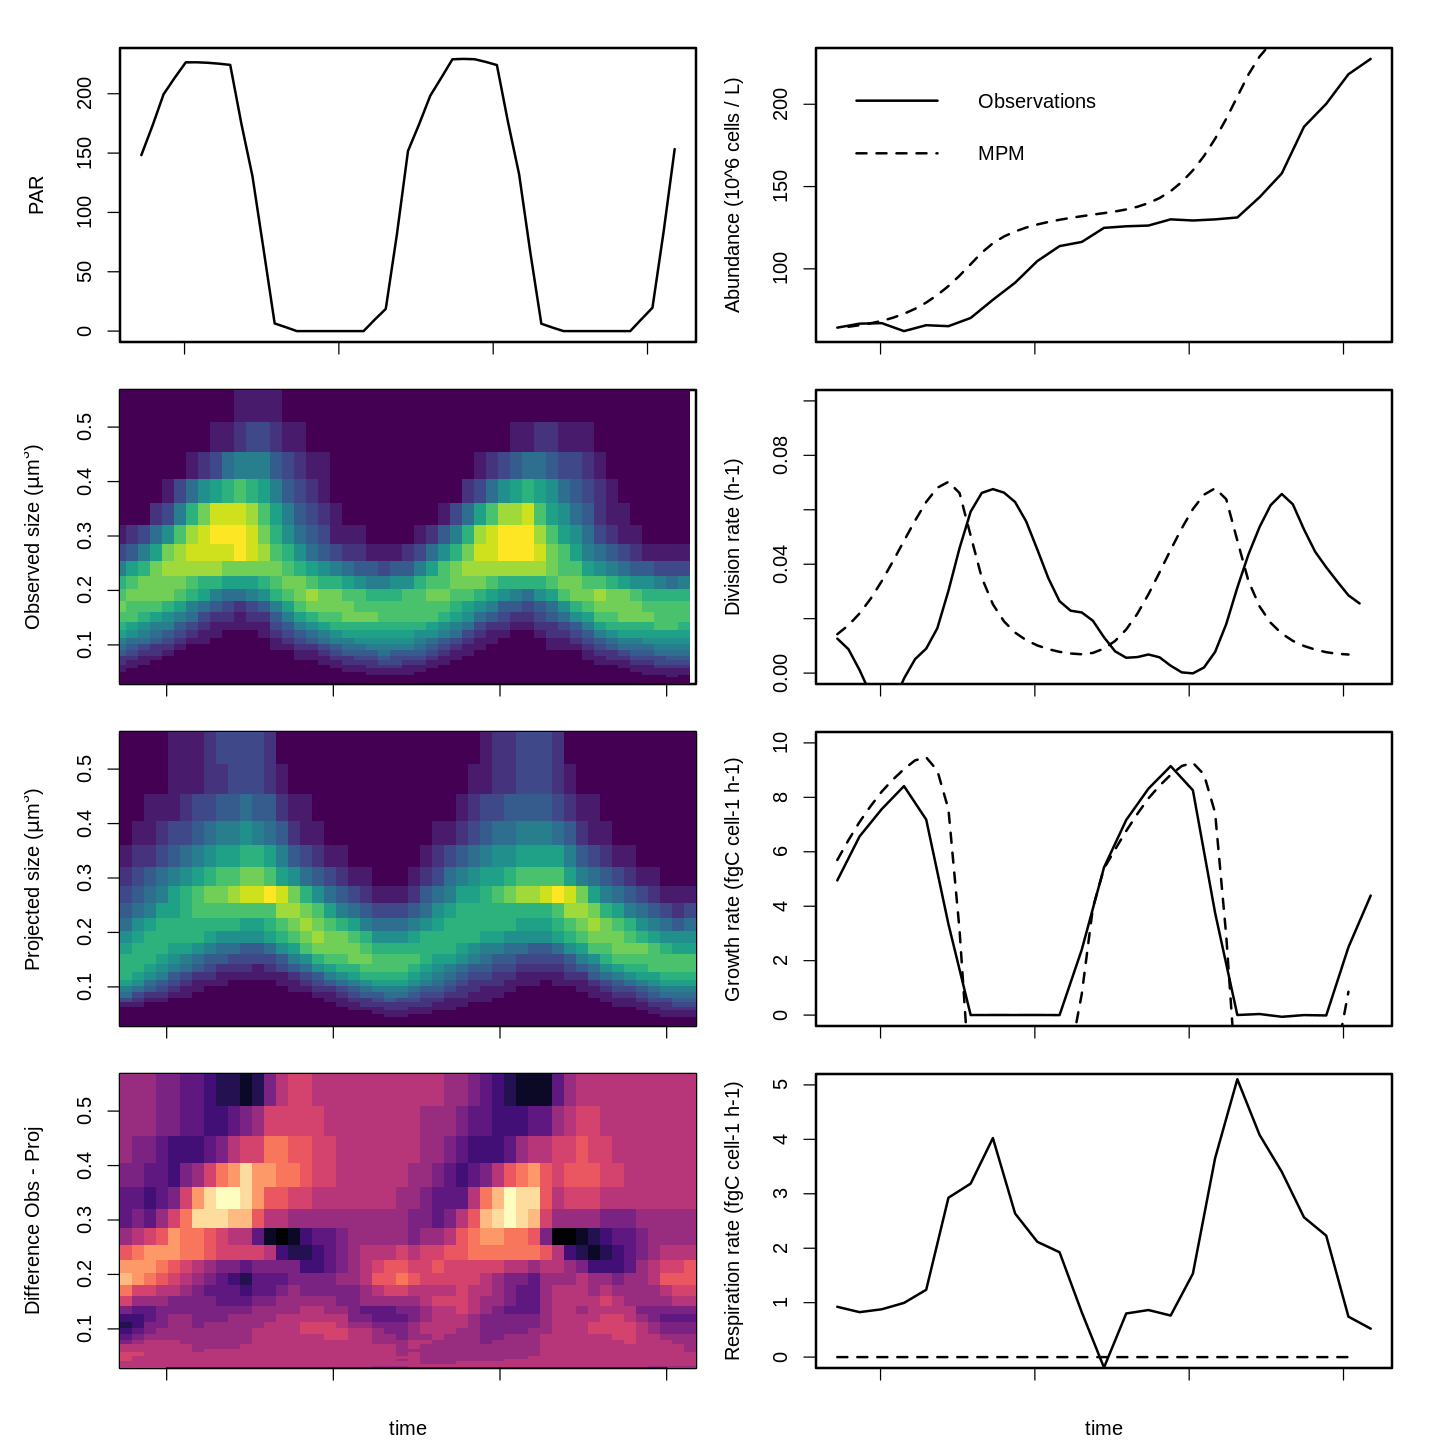

In [55]:
## Comparison Obs vs Model
#    'c1':'../stancode_gallery1/matrixmodel_multinom_estinilnorm_freedelta_normparam_trackgrowth_xval.stan',
#    'c2':'../stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_normparam_trackgrowth_xval.stan',
#    'c3':'../stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_gammaiv6_normparam_trackgrowth_xval.stan',
#    'c4':'../stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respv1_normparam_trackgrowth_xval.stan',
#    'c5':'../stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respv2_normparam_trackgrowth_xval.stan',
#    'c6':'../stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respiv6_normparam_trackgrowth_xval.stan',
#    'c7':'../stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respiv7_normparam_trackgrowth_xval.stan',

i <- 5 # Select model


#colorRampPalette(c("red3", "white","lightblue1"))(15)
options(repr.plot.width = 12, repr.plot.height = 12)
layout(matrix(c(1:8), 4, 2, byrow = FALSE))

par(mar=c(1,4,1,1), oma=c(2,1,1,1), lwd=2, cex=1)

plot(time,PAR,type='l',xaxt='n')
axis(1,labels=NA)
image(x=time[-49],y=v,w_obs[-49,],col=viridis(15), ylab=expression('Observed size ('*mu*'m'^3*')'), xaxt="n", xlim=range(time))
axis(1,labels=NA)
image(x=distribution$time,y=v,t(Vproj[[i]]),col=viridis(15),ylab=expression('Projected size ('*mu*'m'^3*')'), xaxt="n")
axis(1,labels=NA)
image(x=distribution$time,y=v,w_obs[-49,]-t(Vproj[[i]]),col=viridis(15, option="A"),ylab=expression('Difference Obs - Proj'), xaxt="n")
axis(1, labels=NA)
mtext("time", 1, 2)

plot(time, abundance$y/10^6, type='l', xaxt="n", ylab="Abundance (10^6 cells / L)", xlim=range(time))
lines(distribution$time[-1], rowSums(t(Nproj[[i]]))/10^6, lty=2)
legend("topleft", c("Observations","MPM"), lty=c(1,2), bty="n")
axis(1,labels=NA)

plot(x=time[-49],y=dr, type='l', ylim=c(0, 0.1), xaxt='n',xlim=range(time), ylab="Division rate (h-1)")
lines(x=distribution$time[-c(48,49)],y=mu_N[[i]], lty=2)
axis(1,labels=NA)
plot(time2, df2[,3], type='l', xaxt="n", ylim=c(0,10), xlim=range(time),ylab="Growth rate (fgC cell-1 h-1)")
lines(x=distribution$time[-c(48,49)],y=gr[[i]], lty=2)
axis(1,labels=NA)
plot(time2, 0.5 * ( - df2[,3] + df2[,7]), xaxt="n", type='l', ylim=c(0,5), xlim=range(time), ylab="Respiration rate (fgC cell-1 h-1)")
lines(x=distribution$time[-c(48,49)], y = gr[[i]] *0, lty=2)
axis(1, labels=NA)
mtext("time", 1, 2)

Warning message in matrix(c(1:8), 3, 2, byrow = FALSE):
“data length [8] is not a sub-multiple or multiple of the number of rows [3]”


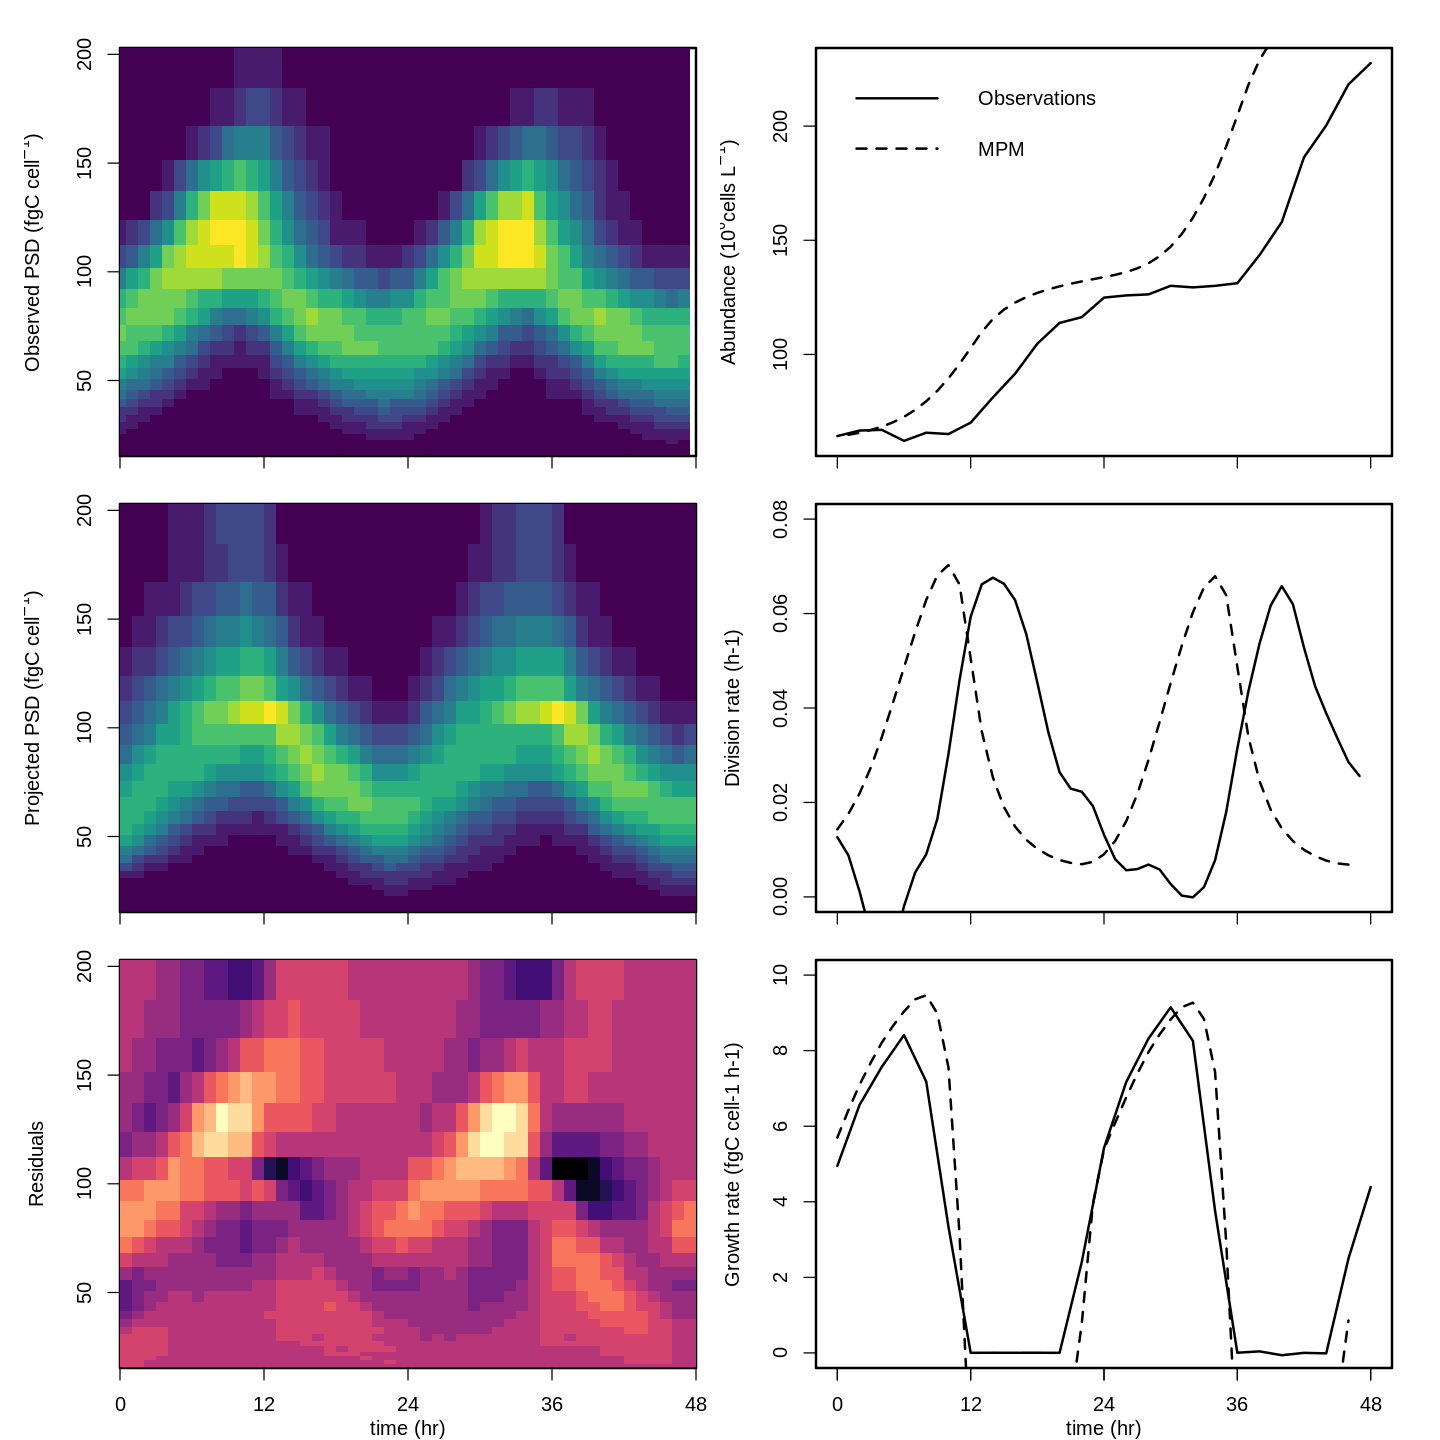

In [71]:
## Comparison Obs vs Model
#    'c1':'../stancode_gallery1/matrixmodel_multinom_estinilnorm_freedelta_normparam_trackgrowth_xval.stan',
#    'c2':'../stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_normparam_trackgrowth_xval.stan',
#    'c3':'../stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_gammaiv6_normparam_trackgrowth_xval.stan',
#    'c4':'../stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respv1_normparam_trackgrowth_xval.stan',
#    'c5':'../stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respv2_normparam_trackgrowth_xval.stan',
#    'c6':'../stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respiv6_normparam_trackgrowth_xval.stan',
#    'c7':'../stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respiv7_normparam_trackgrowth_xval.stan',

i <- 5

#colorRampPalette(c("red3", "white","lightblue1"))(15)
r <- range(as.POSIXct(distribution$time, origin="1970-01-01"))
options(repr.plot.width = 12, repr.plot.height = 12)
layout(matrix(c(1:8), 3, 2, byrow = FALSE))

par(mar=c(1,4,1,1), oma=c(2,1,1,1), lwd=2, cex=1)

# plot(time,PAR,type='l',xaxt='n', ylab=expression('Light (molPhoton m'^-2*'s'^-1*')'))
# axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=NA)
image(x=time[-49],y=c,w_obs[-49,],col=viridis(15), ylab=expression('Observed PSD (fgC cell'^-1*')'), xaxt="n", xlim=range(time))
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=NA)
image(x=distribution$time,y=c,t(Vproj[[i]]),col=viridis(15),ylab=expression('Projected PSD (fgC cell'^-1*')'), xaxt="n")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=NA)
image(x=distribution$time,y=c,w_obs[-25,]-t(Vproj[[i]]),col=viridis(15, option="A"),ylab=expression('Residuals'), xaxt="n")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
mtext("time (hr)", 1, 2)

plot(time, abundance$y/10^6, type='l', xaxt="n", ylab=expression('Abundance (10'^6*'cells L'^-1*')'), xlim=range(time))
lines(time[-1], colSums(Nproj[[i]])/10^6, lty=2)
legend("topleft", c("Observations","MPM"), lty=c(1,2), bty="n")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=NA)

plot(x=time[-49],y=dr, type='l', ylim=c(0, 0.08), xaxt='n',xlim=range(time), ylab="Division rate (h-1)")
lines(x=distribution$time[-c(48,49)],y=mu_N[[i]], lty=2)
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=NA)
plot(time2, df2[,3], type='l', xaxt="n", ylim=c(0,10), xlim=range(time),ylab="Growth rate (fgC cell-1 h-1)")
lines(x=distribution$time[-c(48,49)],y=gr[[i]], lty=2)
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=NA)
# plot(time2, 0.5 * ( - df2[,3] + df2[,7]), xaxt="n", type='l', ylim=c(0,5), xlim=range(time), ylab="Respiration rate (fgC cell-1 h-1)")
# lines(x=distribution$time[-c(23,24)], y = gr[[i]] *0, lty=2)
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
mtext("time (hr)", 1, 2)